In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from pathlib import Path
from os import path
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
import mne
import mni_utils as uti
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from mni_plots import plot_stages_diff

In [3]:
###
# Paths
###

base_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
config_path = Path(path.abspath("")).parent.joinpath("config_mni.yml")

###
# Import data
###

data_path = base_path.joinpath("MatlabFile.mat")
data = loadmat(data_path)
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

###
# Convert data to Dataframe
###

ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = data["SamplingFrequency"][0][0]
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)
df_info["region"] = df_info["region"].apply(lambda x: regions_map[x])

###
# Loop through patients to compute measures
###

pats = df_info["pat"].unique().tolist()

## Test computations with some test data

In [136]:
df_info_test = df_info[df_info["pat"] == pats[5]].reset_index(drop=True)
data_test_W = data_W[df_info.index[df_info["pat"] == pats[5]]]
data_test_N3 = data_N3[df_info.index[df_info["pat"] == pats[5]]]

df_info_test.head()

,pat,chan,type,region,mni_x,mni_y,mni_z
0,6,GD006Rs4,D,Central operculum,49.0,-1.0,6.0
1,6,GD006Rs5,D,Central operculum,53.0,-1.0,7.0
2,6,GD006Rs6,D,Central operculum,57.0,-1.0,6.0
3,6,GD006Rq3,D,Frontal operculum,40.0,24.0,4.0
4,6,GD006Rq4,D,Frontal operculum,43.0,24.0,4.0


In [137]:
# # Raw
# raw_test, idx_good, idx_nan = uti.create_RawMNE(
#     data_test, df_info_test["chan"], sfreq, return_all=True
# )

In [138]:
psds, freqs = mne.time_frequency.psd_array_welch(
    data_test_W,
    sfreq,
    n_fft=int(0.125 * sfreq),
    n_overlap=0,
    average=None,
    window="hann",
)
psds.shape

Effective window size : 0.125 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(14, 13, 544)

In [139]:
# Restrict to gamma frequencies
psds_gamma = psds[:, (freqs >= 40) & (freqs <= 80), :]
# Compute median
psds_gamma = np.median(psds_gamma, axis=1)
psds_gamma[:, np.where(psds_gamma[0] == 0)[0]] = np.nan
# Log transform
psds_gamma = np.log10(psds_gamma)

In [140]:
psds_gamma.shape

(14, 544)

In [77]:
freqs, times, Sxx_test_W = spectrogram(
    data_test_W,
    fs=sfreq,
    window="hann",
    nperseg=int(0.125 * sfreq),
    noverlap=0,
    detrend="constant",
    axis=-1,
)
# Restrict to gamma frequencies
Sxx_gamma_W = Sxx_test_W[:, (freqs >= 40) & (freqs <= 80), :]
# Compute median
Sxx_gamma_W = np.median(Sxx_gamma_W, axis=1)
Sxx_gamma_W[:, np.where(Sxx_gamma_W[0] == 0)[0]] = np.nan
# Log transform
Sxx_gamma_W = np.log10(Sxx_gamma_W)

In [78]:
Sxx_gamma_W.shape

(14, 544)

In [80]:
times

array([6.25000e-02, 1.87500e-01, 3.12500e-01, 4.37500e-01, 5.62500e-01,
       6.87500e-01, 8.12500e-01, 9.37500e-01, 1.06250e+00, 1.18750e+00,
       1.31250e+00, 1.43750e+00, 1.56250e+00, 1.68750e+00, 1.81250e+00,
       1.93750e+00, 2.06250e+00, 2.18750e+00, 2.31250e+00, 2.43750e+00,
       2.56250e+00, 2.68750e+00, 2.81250e+00, 2.93750e+00, 3.06250e+00,
       3.18750e+00, 3.31250e+00, 3.43750e+00, 3.56250e+00, 3.68750e+00,
       3.81250e+00, 3.93750e+00, 4.06250e+00, 4.18750e+00, 4.31250e+00,
       4.43750e+00, 4.56250e+00, 4.68750e+00, 4.81250e+00, 4.93750e+00,
       5.06250e+00, 5.18750e+00, 5.31250e+00, 5.43750e+00, 5.56250e+00,
       5.68750e+00, 5.81250e+00, 5.93750e+00, 6.06250e+00, 6.18750e+00,
       6.31250e+00, 6.43750e+00, 6.56250e+00, 6.68750e+00, 6.81250e+00,
       6.93750e+00, 7.06250e+00, 7.18750e+00, 7.31250e+00, 7.43750e+00,
       7.56250e+00, 7.68750e+00, 7.81250e+00, 7.93750e+00, 8.06250e+00,
       8.18750e+00, 8.31250e+00, 8.43750e+00, 8.56250e+00, 8.687

In [117]:
freqs, times, Sxx_test_W = spectrogram(
    data_test_W,
    fs=sfreq,
    window="hann",
    nperseg=int(0.125 * sfreq),
    noverlap=int(0.8 * 0.125 * sfreq),
    detrend="constant",
    axis=-1,
)
# Restrict to gamma frequencies
Sxx_gamma_W = Sxx_test_W[:, (freqs >= 40) & (freqs <= 80), :]
# Compute median
Sxx_gamma_W = np.median(Sxx_gamma_W, axis=1)
# Convolve
Sxx_gamma_W = [np.convolve(Sxx_gamma_W[ch], 1 / np.array([5, 4, 3, 2, 1, 2, 3, 4, 5]), mode="same")[::5]
               for ch in range(Sxx_gamma_W.shape[0])]
Sxx_gamma_W = np.array(Sxx_gamma_W)
Sxx_gamma_W[:, np.where(Sxx_gamma_W[0] == 0)[0]] = np.nan
# Log transform
Sxx_gamma_W = np.log10(Sxx_gamma_W)

# # N3
# freqs, times, Sxx_test_N3 = spectrogram(
#                 data_test_N3,
#                 fs=sfreq,
#                 window="hamming",
#                 nperseg=int(0.125 * sfreq),
#                 noverlap=0,
#                 detrend="linear",
#                 axis=-1,
#             )
# # Restrict to gamma frequencies
# Sxx_gamma_N3 = Sxx_test_N3[:, (freqs >= 40) & (freqs <= 80), :]
# # Compute median
# Sxx_gamma_N3 = np.median(Sxx_gamma_N3, axis=1)
# Sxx_gamma_N3[:, np.where(Sxx_gamma_N3[0] == 0)[0]] = np.nan
# # Log transform
# Sxx_gamma_N3 = np.log(Sxx_gamma_N3)

In [116]:
Sxx_test_W.shape

(14, 13, 2716)

In [118]:
Sxx_gamma_W.shape

(14, 544)

In [114]:
544*5

2720

In [115]:
np.convolve(Sxx_gamma_W[0], 1 / np.array([5, 4, 3, 2, 1, 2, 3, 4, 5]), mode="same")[::5].shape

(544,)

In [106]:
times

array([6.25000e-02, 1.27500e-01, 1.92500e-01, ..., 6.77925e+01,
       6.78575e+01, 6.79225e+01])

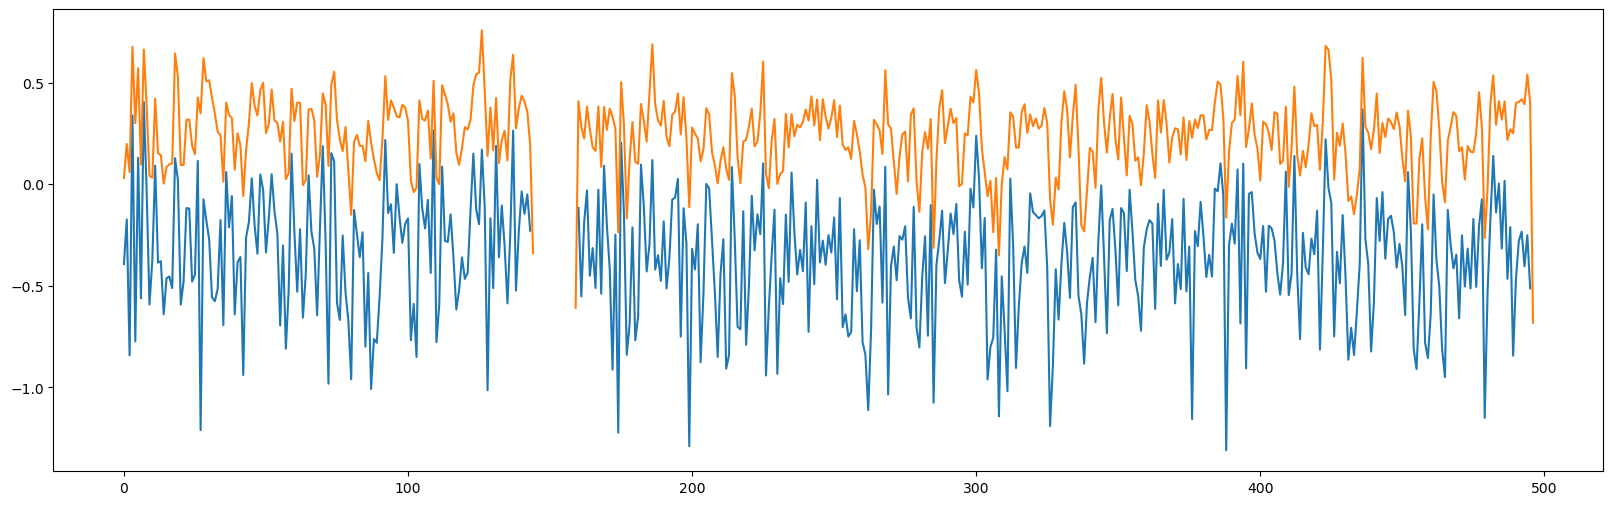

In [119]:
plt.figure(figsize=[20, 6])
plt.plot(psds_gamma[0])
plt.plot(Sxx_gamma_W[0])
plt.show()

Compute from raw:

In [141]:
raw_test, idx_good, idx_nan = uti.create_RawMNE(
    data_test_W, df_info_test["chan"], sfreq, return_all=True
)
psds_raw = raw_test.compute_psd(
    n_fft=int(0.125 * sfreq), n_overlap=0, average=None, window="hann"
)
psds_raw, freqs = psds_raw.get_data(), psds_raw.freqs

Setting 1598 of 13600 (11.75%) samples to NaN, retaining 12002 (88.25%) samples.
Effective window size : 0.125 (s)


In [142]:
# Restrict to gamma frequencies
psds_gamma_raw = psds_raw[:, (freqs >= 40) & (freqs <= 80), :]
# Compute median
psds_gamma_raw = np.median(psds_gamma_raw, axis=1)
# Log transform
psds_gamma_raw = np.log10(psds_gamma_raw)

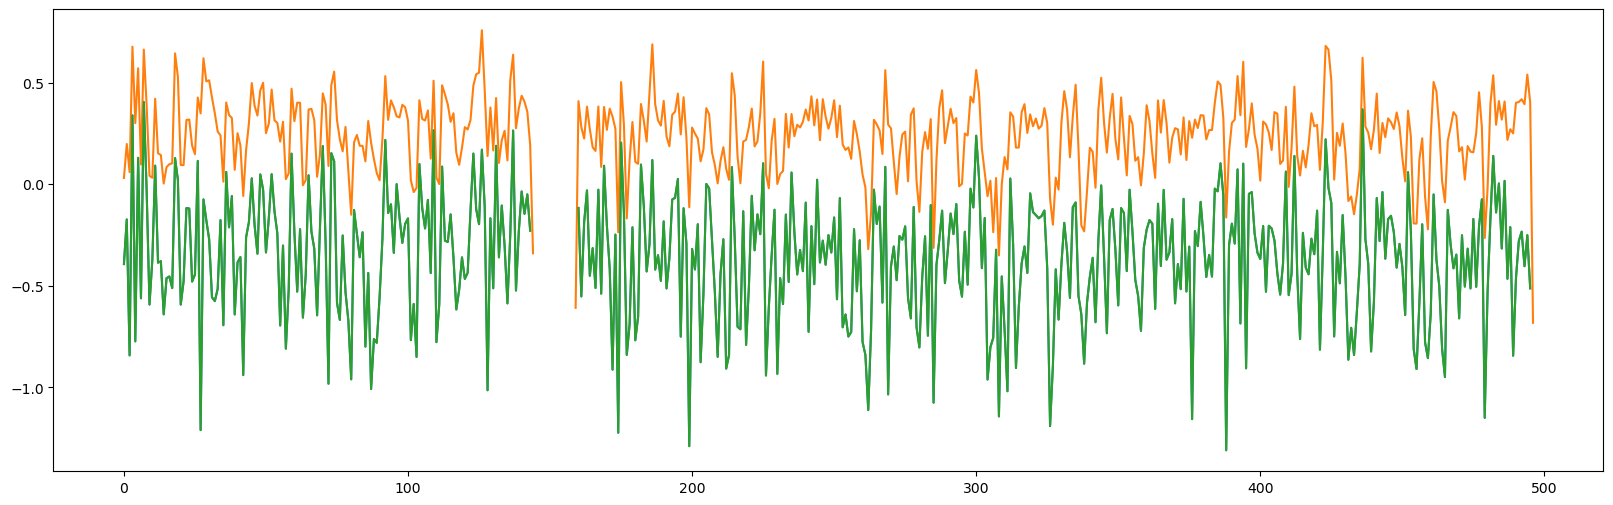

In [143]:
plt.figure(figsize=[20, 6])
plt.plot(psds_gamma[0])
plt.plot(Sxx_gamma_W[0])
plt.plot(psds_gamma_raw[0])
# plt.xlim(0, 10)
plt.show()

Compute ACF

In [144]:
acfs_gamma_W = [
    acf(Sxx, nlags=240, adjusted=True, missing="drop") for Sxx in psds_gamma_raw
]


# acfs_gamma_N3 = [acf(Sxx, nlags=200, adjusted=True, missing="drop") for Sxx in Sxx_gamma_N3]

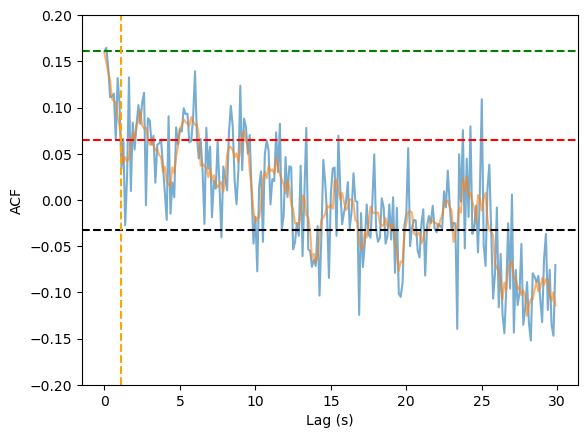

In [145]:
t = np.arange(len(acfs_gamma_W[3]) - 1) * 0.125
y_ma = uniform_filter1d(acfs_gamma_W[3][1:], size=5)

plt.plot(t, acfs_gamma_W[3][1:], alpha=0.6)
plt.plot(t, y_ma, alpha=0.6)
base_val = np.median(acfs_gamma_W[3][1:][t > 15])
plt.axhline(base_val, color="k", linestyle="--")
half_val = (acfs_gamma_W[3][1] + base_val) / 2  # + base_val
plt.axhline(half_val, color="r", linestyle="--")
plt.axhline(acfs_gamma_W[3][1], color="g", linestyle="--")
plt.axvline(1.125, color="orange", linestyle="--")
plt.ylim(-0.2, 0.2)
plt.xlabel("Lag (s)")
plt.ylabel("ACF")
plt.show()

In [19]:
np.where(y_ma < half_val)[0][0] * 0.125

1.25

## Functions

In [121]:
def compute_acf_gamma(data, sfreq, t_bin=0.125, freqs_gamma=[40, 80],
                      overlap=False):
    
    if overlap:
        overlap = 0.8
    else:
        overlap = 0

    # Compute PSD
    freqs, times, psds_raw = spectrogram(
        data,
        fs=sfreq,
        window="hann",
        nperseg=int(t_bin * sfreq),
        noverlap=int(overlap * t_bin * sfreq),
        detrend="constant",
        axis=-1,
    )
    # Restrict to gamma frequencies
    psds_gamma_raw = psds_raw[
        :, (freqs >= freqs_gamma[0]) & (freqs <= freqs_gamma[1]), :
    ]
    # Compute median
    psds_gamma_raw = np.median(psds_gamma_raw, axis=1)
    # Convolve if overlap
    if overlap:
        psds_gamma_raw = [np.convolve(psds_gamma_raw[ch], 1 / np.array([5, 4, 3, 2, 1, 2, 3, 4, 5]), mode="same")[::5]
                        for ch in range(psds_gamma_raw.shape[0])]
        psds_gamma_raw = np.array(psds_gamma_raw)
    # Replace NaNs with zeros
    psds_gamma_raw[:, np.where(psds_gamma_raw[0] == 0)[0]] = np.nan
    # Log transform
    psds_gamma_raw = np.log10(psds_gamma_raw)

    # Compute ACF
    acfs_gamma = [
        (
            acf(Sxx, nlags=240, adjusted=True, missing="drop")
            if not np.isnan(Sxx).all()
            else np.nan
        )
        for Sxx in psds_gamma_raw
    ]

    return acfs_gamma


def compute_tau_meisel(acf_func, idx_comp, smoothing=None):

    if smoothing is not None:
        acf_func_filt = uniform_filter1d(acf_func[1:], size=smoothing)
    else:
        acf_func_filt = acf_func[1:].copy()

    base_val = np.median(acf_func_filt[idx_comp:])
    half_val = (acf_func_filt[0] + base_val) / 2
    idx_half = np.where(acf_func_filt < half_val)[0][0]

    return idx_half + 1


def compute_df_tau(
    data_W, data_N3, data_R, df_info, sfreq, freqs_gamma=[40, 80], smoothing=None,
    overlap=False
):

    pats = []
    chan = []
    region = []
    taus_W = []
    taus_N3 = []
    taus_R = []

    for pat in df_info["pat"].unique():
        df_info_pat = df_info[df_info["pat"] == pat].reset_index(drop=True)
        data_pat_W = data_W[df_info.index[df_info["pat"] == pat]]
        data_pat_N3 = data_N3[df_info.index[df_info["pat"] == pat]]
        data_pat_R = data_R[df_info.index[df_info["pat"] == pat]]

        acfs_gamma_W = compute_acf_gamma(data_pat_W, sfreq, freqs_gamma=freqs_gamma, overlap=overlap)
        taus_pat_W = [
            compute_tau_meisel(acf, 120, smoothing) * 0.125 for acf in acfs_gamma_W
        ]

        if not np.isnan(data_pat_N3).all():
            acfs_gamma_N3 = compute_acf_gamma(
                data_pat_N3, sfreq, freqs_gamma=freqs_gamma
            )
            taus_pat_N3 = [
                (
                    compute_tau_meisel(acf, 120, smoothing) * 0.125
                    if not np.isnan(acf).all()
                    else np.nan
                )
                for acf in acfs_gamma_N3
            ]
        else:
            taus_pat_N3 = [np.nan] * len(df_info_pat)

        if not np.isnan(data_pat_R).all():
            acfs_gamma_R = compute_acf_gamma(data_pat_R, sfreq, freqs_gamma=freqs_gamma)
            taus_pat_R = [
                (
                    compute_tau_meisel(acf, 120, smoothing) * 0.125
                    if not np.isnan(acf).all()
                    else np.nan
                )
                for acf in acfs_gamma_R
            ]
        else:
            taus_pat_R = [np.nan] * len(df_info_pat)

        taus_W += taus_pat_W
        taus_N3 += taus_pat_N3
        taus_R += taus_pat_R
        pats += [pat] * len(df_info_pat)
        chan += df_info_pat["chan"].tolist()
        region += df_info_pat["region"].tolist()

    df_taus = pd.DataFrame(
        {
            "pat": pats,
            "chan": chan,
            "region": region,
            "tau_W": taus_W,
            "tau_N3": taus_N3,
            "tau_R": taus_R,
        }
    )

    return df_taus

## Compute without smoothing

In [17]:
df_taus = compute_df_tau(data_W, data_N3, data_R, df_info, sfreq, smoothing=None)
df_taus

C:\Users\ricca\AppData\Local\Temp\ipykernel_20080\1992038359.py:22: RuntimeWarning: divide by zero encountered in log10
  psds_gamma_raw = np.log10(psds_gamma_raw)
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\statsmodels\tsa\stattools.py:470: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Middle temporal gyrus,0.250,NaN,NaN
1,1,GD001Lc_12,Middle temporal gyrus,0.250,NaN,NaN
2,1,GD001Lc_13,Middle temporal gyrus,0.250,NaN,NaN
3,1,GD001Lc_14,Middle temporal gyrus,0.625,NaN,NaN
4,1,GD001Lo_1,Medial frontal cortex,0.375,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Postcentral gyrus (including medial segment),0.375,0.375,1.625
1768,110,NG110RG64,Frontal operculum,0.500,0.375,0.250
1769,110,NG110RG65,Frontal operculum,0.625,0.375,0.250
1770,110,NG110RI101,Supplementary motor cortex,0.250,0.375,3.750


Distributions:

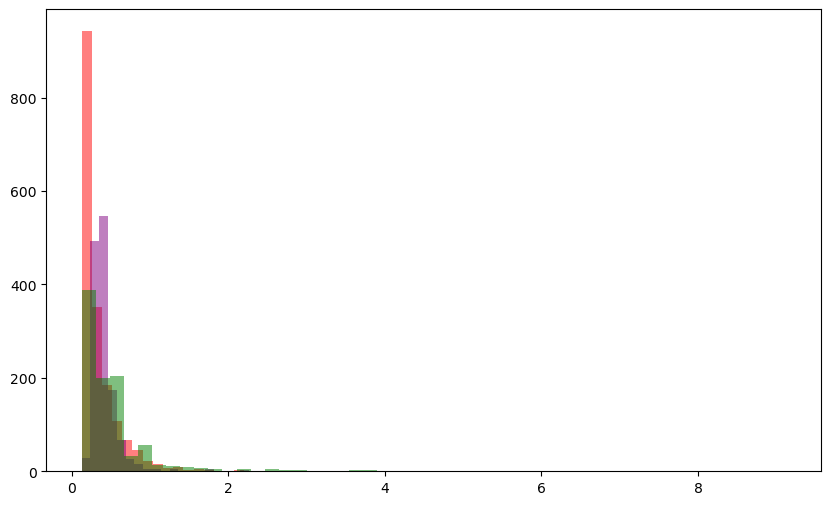

Means: 0.39058972911963885 0.3996376811594203 0.5295120671563484
Medians: 0.25 0.375 0.375


In [18]:
plt.figure(figsize=[10, 6])
plt.hist(df_taus["tau_W"], color="r", bins=50, alpha=0.5)
plt.hist(df_taus["tau_N3"], color="purple", bins=50, alpha=0.5)
plt.hist(df_taus["tau_R"], color="g", bins=50, alpha=0.5)
plt.show()

print(
    "Means:",
    np.nanmean(df_taus["tau_W"]),
    np.nanmean(df_taus["tau_N3"]),
    np.nanmean(df_taus["tau_R"]),
)
print(
    "Medians:",
    np.nanmedian(df_taus["tau_W"]),
    np.nanmedian(df_taus["tau_N3"]),
    np.nanmedian(df_taus["tau_R"]),
)

Mean and median across electrodes:

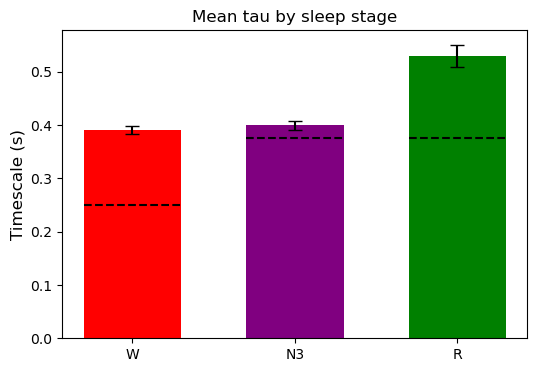

In [19]:
plt.figure(figsize=[6, 4])
plt.bar(
    ["W", "N3", "R"],
    df_taus[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot([-0.3, 0.3], [df_taus["tau_W"].median(), df_taus["tau_W"].median()], "k--")
plt.plot([0.7, 1.3], [df_taus["tau_N3"].median(), df_taus["tau_N3"].median()], "k--")
plt.plot([1.7, 2.3], [df_taus["tau_R"].median(), df_taus["tau_R"].median()], "k--")
plt.title("Mean tau by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by patient:

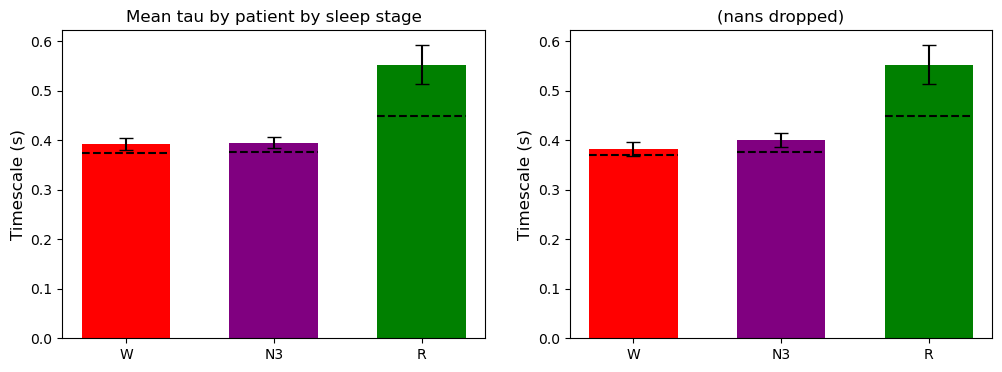

In [20]:
df_taus_pat = df_taus[["pat", "tau_W", "tau_N3", "tau_R"]].groupby("pat").mean()

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("Mean tau by patient by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)

# Drop patients without sleep
df_taus_pat = df_taus_pat.dropna()
plt.subplot(1, 2, 2)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("(nans dropped)")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by brain region:

In [22]:
df_taus_reg = df_taus[["region", "tau_W", "tau_N3", "tau_R"]].groupby("region").mean()
df_taus_reg = pd.melt(
    df_taus_reg.reset_index(),
    id_vars="region",
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_reg["stage"] = df_taus_reg["stage"].str.replace("tau_", "")
df_taus_reg

,region,stage,tau
0,Amygdala,W,0.333333
1,Angular gyrus,W,0.643868
2,Anterior cingulate,W,0.383065
3,Anterior insula,W,0.357394
4,Calcarine cortex,W,0.250000
...,...,...,...
109,Supplementary motor cortex,R,0.763393
110,Supramarginal gyrus,R,0.530172
111,Temporal pole and planum polare,R,1.160714
112,Transverse temporal gyrus,R,0.187500


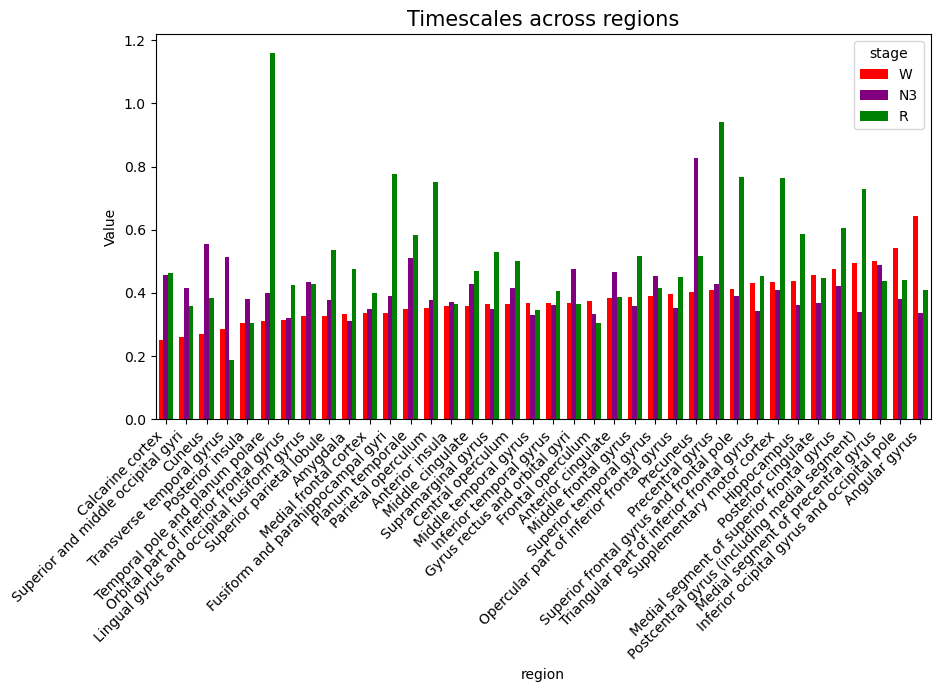

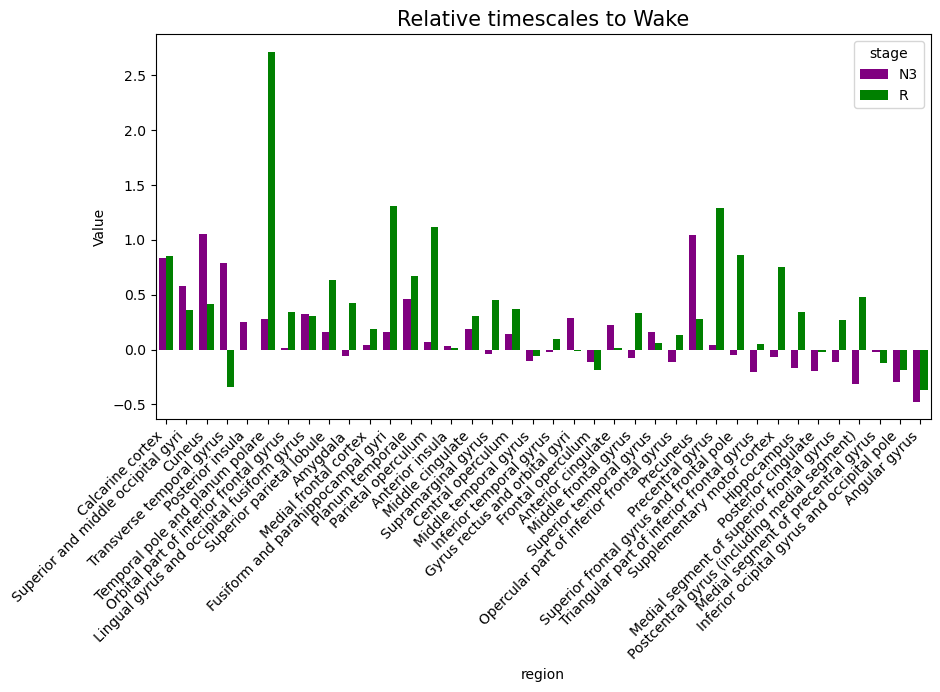

In [23]:
plot_stages_diff(df_taus_reg, "tau")

Same plot for lobes:

In [24]:
df_regions_info = pd.read_csv(base_path.joinpath("RegionInformation.csv"), index_col=0)
df_regions_info["Region name"] = df_regions_info["Region name"].str.strip("'")
df_regions_info.set_index("Region name", inplace=True)

df_taus_lobe = df_taus.copy()
df_taus_lobe.insert(2, "lobe", df_taus_lobe["region"].apply(
    lambda x: df_regions_info.loc[x, "Lobe"]
))
df_taus_lobe.drop(columns="region", inplace=True)
df_taus_lobe.rename(columns={"lobe": "region"}, inplace=True)
df_taus_lobe

,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Temporal,0.250,NaN,NaN
1,1,GD001Lc_12,Temporal,0.250,NaN,NaN
2,1,GD001Lc_13,Temporal,0.250,NaN,NaN
3,1,GD001Lc_14,Temporal,0.625,NaN,NaN
4,1,GD001Lo_1,Frontal,0.375,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Parietal,0.375,0.375,1.625
1768,110,NG110RG64,Frontal,0.500,0.375,0.250
1769,110,NG110RG65,Frontal,0.625,0.375,0.250
1770,110,NG110RI101,Frontal,0.250,0.375,3.750


In [25]:
df_taus_lobe = df_taus_lobe[["region", "tau_W", "tau_N3", "tau_R"]].groupby("region").mean()
df_taus_lobe = pd.melt(
    df_taus_lobe.reset_index(),
    id_vars="region",
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_lobe["stage"] = df_taus_lobe["stage"].str.replace("tau_", "")
df_taus_lobe

,region,stage,tau
0,Frontal,W,0.396173
1,Insula,W,0.339623
2,Occipital,W,0.342548
3,Parietal,W,0.435552
4,Temporal,W,0.366505
5,Frontal,N3,0.395400
6,Insula,N3,0.373418
7,Occipital,N3,0.441964
8,Parietal,N3,0.419028
9,Temporal,N3,0.389130


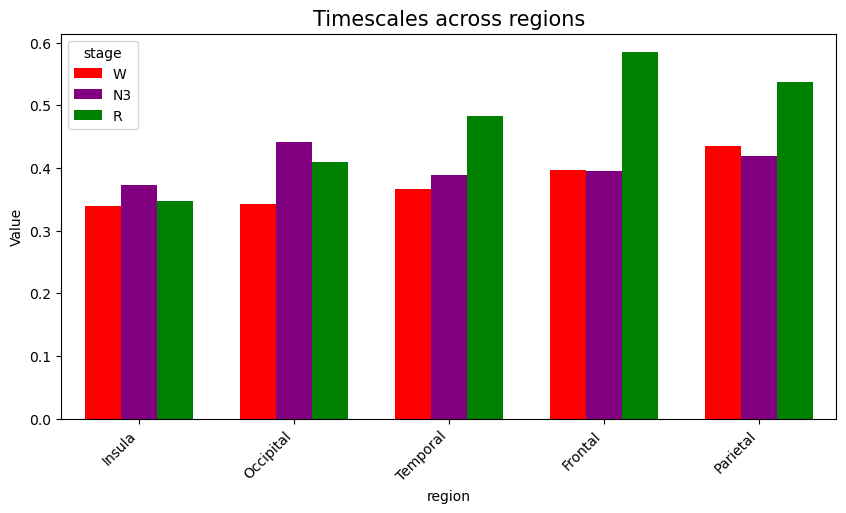

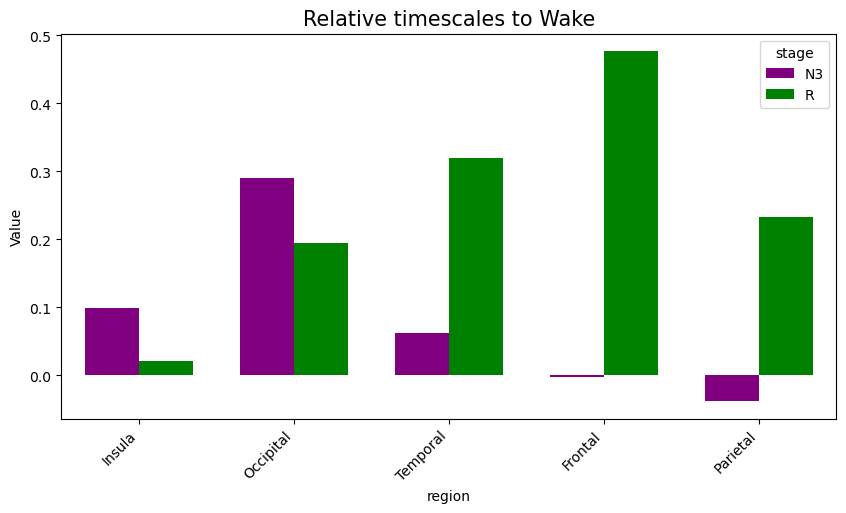

In [26]:
plot_stages_diff(df_taus_lobe, "tau")

## Compute with some smoothing on the ACFs (closest approach)

In [27]:
df_taus = compute_df_tau(data_W, data_N3, data_R, df_info, sfreq, smoothing=5)
df_taus

C:\Users\ricca\AppData\Local\Temp\ipykernel_20080\1992038359.py:22: RuntimeWarning: divide by zero encountered in log10
  psds_gamma_raw = np.log10(psds_gamma_raw)
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\statsmodels\tsa\stattools.py:470: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Middle temporal gyrus,0.375,NaN,NaN
1,1,GD001Lc_12,Middle temporal gyrus,0.875,NaN,NaN
2,1,GD001Lc_13,Middle temporal gyrus,0.125,NaN,NaN
3,1,GD001Lc_14,Middle temporal gyrus,1.000,NaN,NaN
4,1,GD001Lo_1,Medial frontal cortex,0.375,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Postcentral gyrus (including medial segment),0.625,0.500,5.125
1768,110,NG110RG64,Frontal operculum,0.375,0.375,0.500
1769,110,NG110RG65,Frontal operculum,0.625,0.375,0.750
1770,110,NG110RI101,Supplementary motor cortex,2.250,0.500,3.500


Distributions:

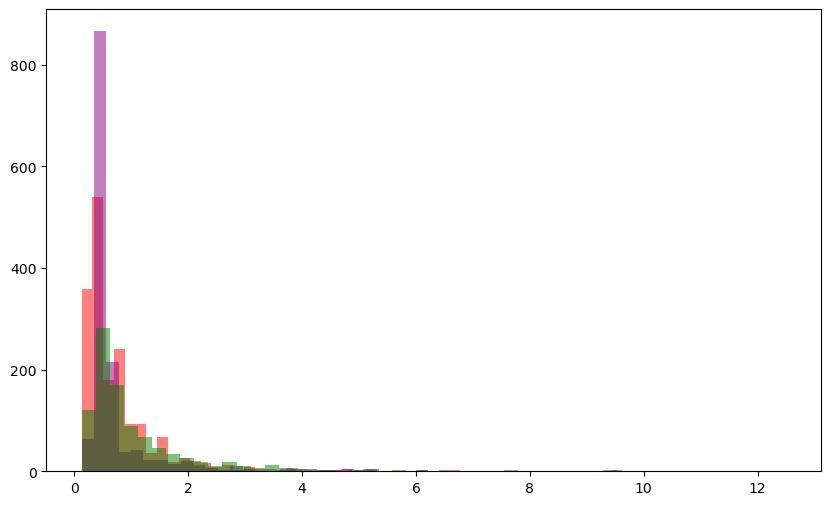

Means: 0.8309113995485328 0.7590579710144928 1.1164742917103883
Medians: 0.5 0.5 0.625


In [28]:
plt.figure(figsize=[10, 6])
plt.hist(df_taus["tau_W"], color="r", bins=50, alpha=0.5)
plt.hist(df_taus["tau_N3"], color="purple", bins=50, alpha=0.5)
plt.hist(df_taus["tau_R"], color="g", bins=50, alpha=0.5)
plt.show()

print(
    "Means:",
    np.nanmean(df_taus["tau_W"]),
    np.nanmean(df_taus["tau_N3"]),
    np.nanmean(df_taus["tau_R"]),
)
print(
    "Medians:",
    np.nanmedian(df_taus["tau_W"]),
    np.nanmedian(df_taus["tau_N3"]),
    np.nanmedian(df_taus["tau_R"]),
)

Mean and median across electrodes:

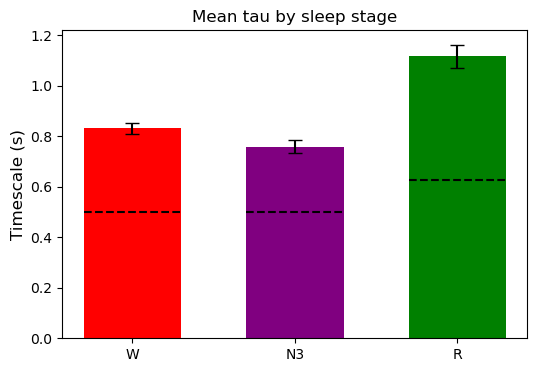

In [29]:
plt.figure(figsize=[6, 4])
plt.bar(
    ["W", "N3", "R"],
    df_taus[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot([-0.3, 0.3], [df_taus["tau_W"].median(), df_taus["tau_W"].median()], "k--")
plt.plot([0.7, 1.3], [df_taus["tau_N3"].median(), df_taus["tau_N3"].median()], "k--")
plt.plot([1.7, 2.3], [df_taus["tau_R"].median(), df_taus["tau_R"].median()], "k--")
plt.title("Mean tau by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by patient:

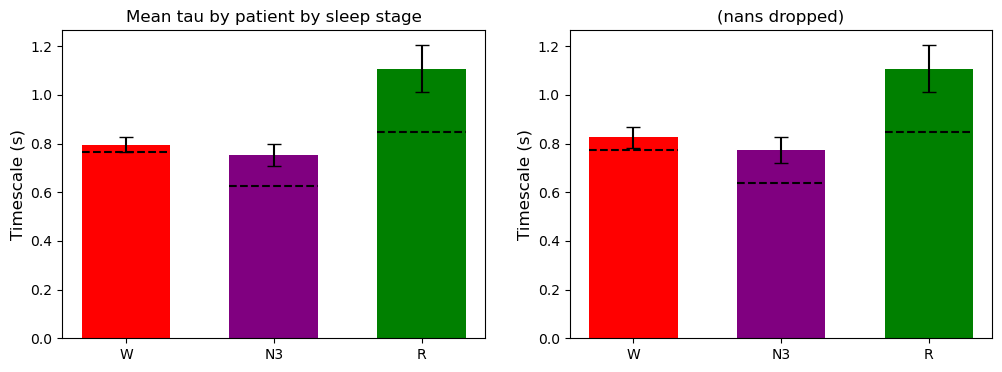

In [30]:
df_taus_pat = df_taus[["pat", "tau_W", "tau_N3", "tau_R"]].groupby("pat").mean()

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("Mean tau by patient by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)

# Drop patients without sleep
df_taus_pat = df_taus_pat.dropna()
plt.subplot(1, 2, 2)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("(nans dropped)")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by brain region:

In [59]:
df_taus_reg = df_taus[["region", "tau_W", "tau_N3", "tau_R"]].copy() #groupby("region").mean()
df_taus_reg = pd.melt(
    df_taus_reg.reset_index(),
    id_vars="region",
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_reg["stage"] = df_taus_reg["stage"].str.replace("tau_", "")
df_taus_reg

,region,stage,tau
0,Middle temporal gyrus,W,0.375
1,Middle temporal gyrus,W,0.875
2,Middle temporal gyrus,W,0.125
3,Middle temporal gyrus,W,1.000
4,Medial frontal cortex,W,0.375
...,...,...,...
5311,Postcentral gyrus (including medial segment),R,5.125
5312,Frontal operculum,R,0.500
5313,Frontal operculum,R,0.750
5314,Supplementary motor cortex,R,3.500


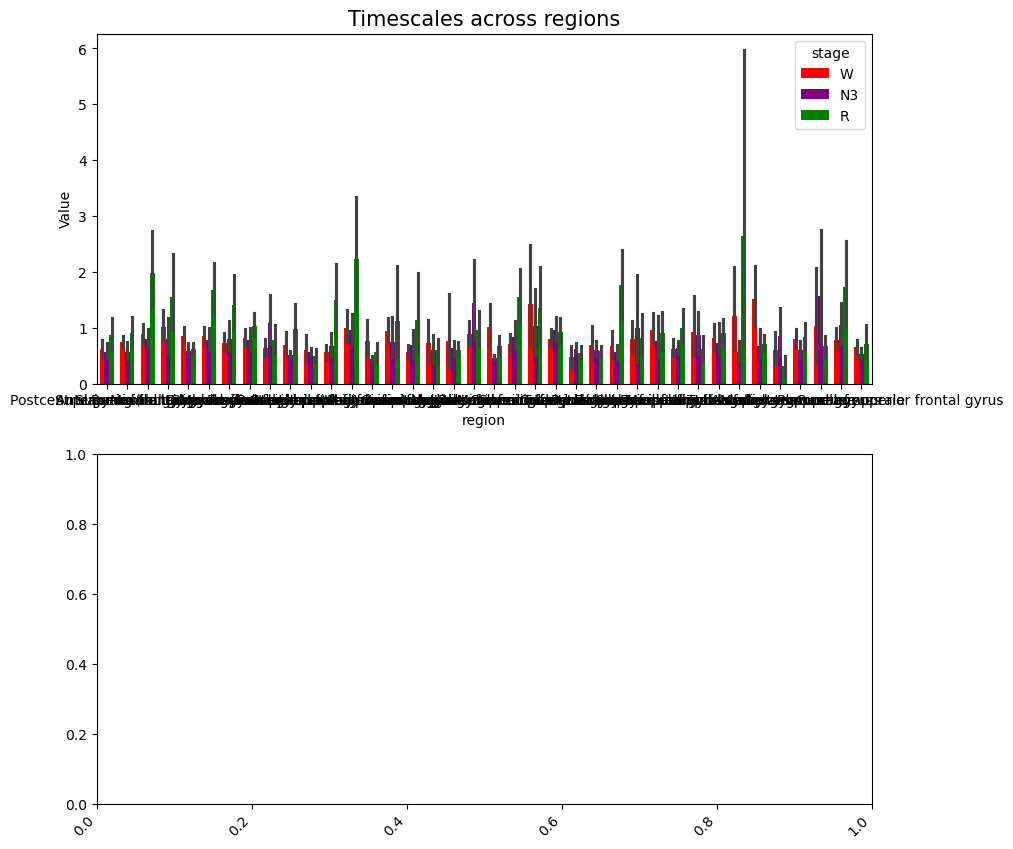

In [62]:
fig, axs = plot_stages_diff(df_taus_reg, "tau")

plt.show()

Same plot for lobes:

In [54]:
df_regions_info = pd.read_csv(base_path.joinpath("RegionInformation.csv"), index_col=0)
df_regions_info["Region name"] = df_regions_info["Region name"].str.strip("'")
df_regions_info.set_index("Region name", inplace=True)

df_taus_lobe = df_taus.copy()
df_taus_lobe.insert(2, "lobe", df_taus_lobe["region"].apply(
    lambda x: df_regions_info.loc[x, "Lobe"]
))
df_taus_lobe.drop(columns="region", inplace=True)
df_taus_lobe.rename(columns={"lobe": "region"}, inplace=True)
df_taus_lobe

,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Temporal,0.375,NaN,NaN
1,1,GD001Lc_12,Temporal,0.875,NaN,NaN
2,1,GD001Lc_13,Temporal,0.125,NaN,NaN
3,1,GD001Lc_14,Temporal,1.000,NaN,NaN
4,1,GD001Lo_1,Frontal,0.375,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Parietal,0.625,0.500,5.125
1768,110,NG110RG64,Frontal,0.375,0.375,0.500
1769,110,NG110RG65,Frontal,0.625,0.375,0.750
1770,110,NG110RI101,Frontal,2.250,0.500,3.500


In [55]:
df_taus_lobe = df_taus_lobe[["region", "chan", "tau_W", "tau_N3", "tau_R"]].copy() #.groupby("region").mean()
df_taus_lobe = pd.melt(
    df_taus_lobe.reset_index(),
    id_vars=["region", "chan"],
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_lobe["stage"] = df_taus_lobe["stage"].str.replace("tau_", "")
df_taus_lobe

,region,chan,stage,tau
0,Temporal,GD001Lc_11,W,0.375
1,Temporal,GD001Lc_12,W,0.875
2,Temporal,GD001Lc_13,W,0.125
3,Temporal,GD001Lc_14,W,1.000
4,Frontal,GD001Lo_1,W,0.375
...,...,...,...,...
5311,Parietal,NG110RG614,R,5.125
5312,Frontal,NG110RG64,R,0.500
5313,Frontal,NG110RG65,R,0.750
5314,Frontal,NG110RI101,R,3.500


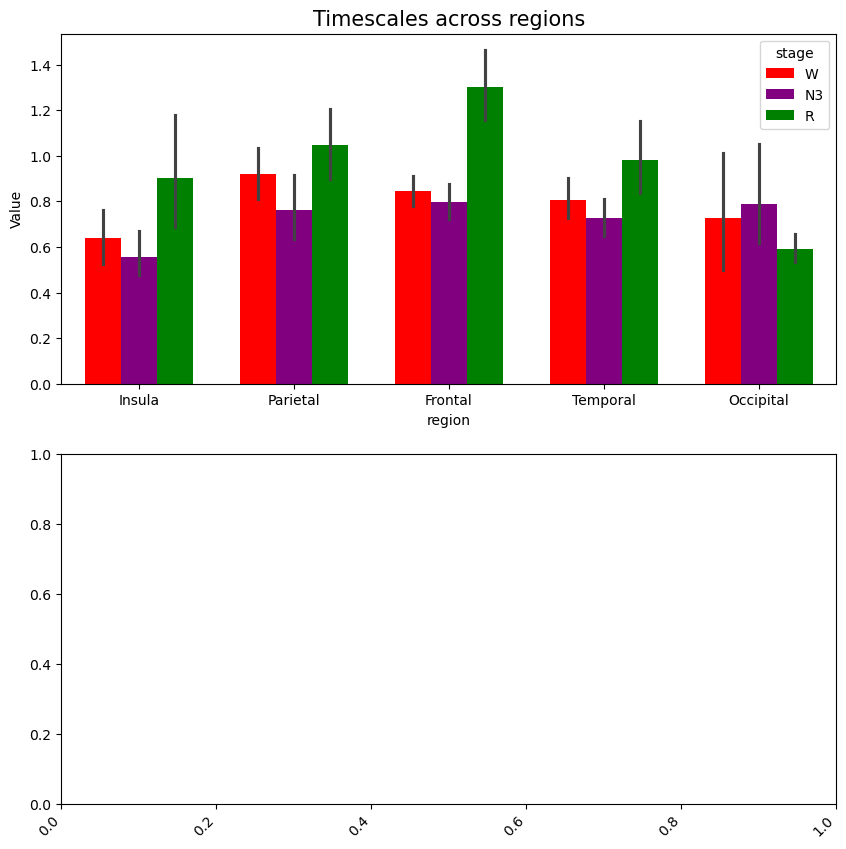

In [58]:
fig, axs = plot_stages_diff(df_taus_lobe, "tau", avg="mean")

plt.show()

## Compute with some overlapping in PSDs

In [126]:
df_taus = compute_df_tau(data_W, data_N3, data_R, df_info, sfreq, overlap=True, smoothing=5)
df_taus

C:\Users\ricca\AppData\Local\Temp\ipykernel_20080\1184153812.py:33: RuntimeWarning: divide by zero encountered in log10
  psds_gamma_raw = np.log10(psds_gamma_raw)
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\statsmodels\tsa\stattools.py:470: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Middle temporal gyrus,0.500,NaN,NaN
1,1,GD001Lc_12,Middle temporal gyrus,0.500,NaN,NaN
2,1,GD001Lc_13,Middle temporal gyrus,0.375,NaN,NaN
3,1,GD001Lc_14,Middle temporal gyrus,0.500,NaN,NaN
4,1,GD001Lo_1,Medial frontal cortex,0.500,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Postcentral gyrus (including medial segment),1.125,0.500,5.125
1768,110,NG110RG64,Frontal operculum,0.500,0.375,0.500
1769,110,NG110RG65,Frontal operculum,0.500,0.375,0.750
1770,110,NG110RI101,Supplementary motor cortex,0.500,0.500,3.500


Distributions:

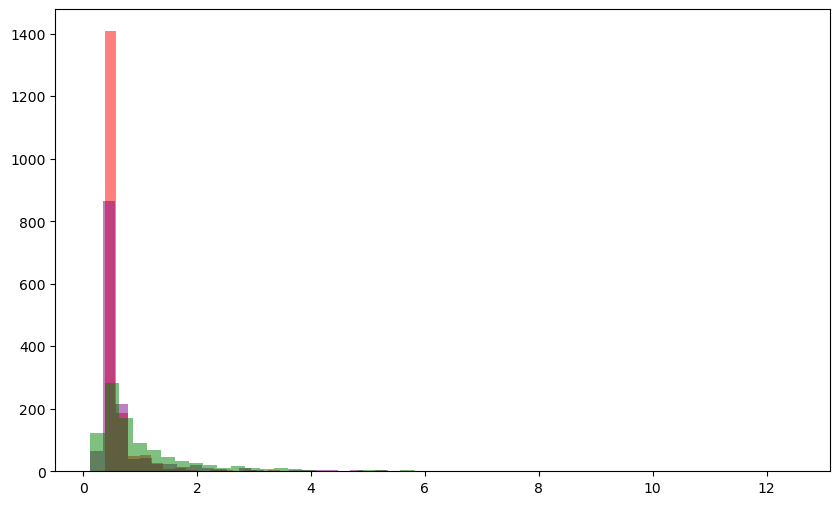

Means: 0.6005220090293454 0.7590579710144928 1.1164742917103883
Medians: 0.5 0.5 0.625


In [127]:
plt.figure(figsize=[10, 6])
plt.hist(df_taus["tau_W"], color="r", bins=50, alpha=0.5)
plt.hist(df_taus["tau_N3"], color="purple", bins=50, alpha=0.5)
plt.hist(df_taus["tau_R"], color="g", bins=50, alpha=0.5)
plt.show()

print(
    "Means:",
    np.nanmean(df_taus["tau_W"]),
    np.nanmean(df_taus["tau_N3"]),
    np.nanmean(df_taus["tau_R"]),
)
print(
    "Medians:",
    np.nanmedian(df_taus["tau_W"]),
    np.nanmedian(df_taus["tau_N3"]),
    np.nanmedian(df_taus["tau_R"]),
)

Mean and median across electrodes:

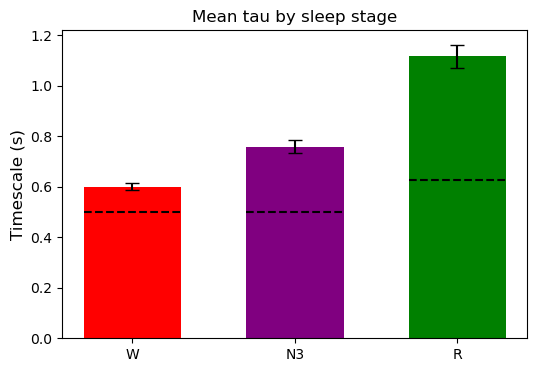

In [128]:
plt.figure(figsize=[6, 4])
plt.bar(
    ["W", "N3", "R"],
    df_taus[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot([-0.3, 0.3], [df_taus["tau_W"].median(), df_taus["tau_W"].median()], "k--")
plt.plot([0.7, 1.3], [df_taus["tau_N3"].median(), df_taus["tau_N3"].median()], "k--")
plt.plot([1.7, 2.3], [df_taus["tau_R"].median(), df_taus["tau_R"].median()], "k--")
plt.title("Mean tau by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by patient:

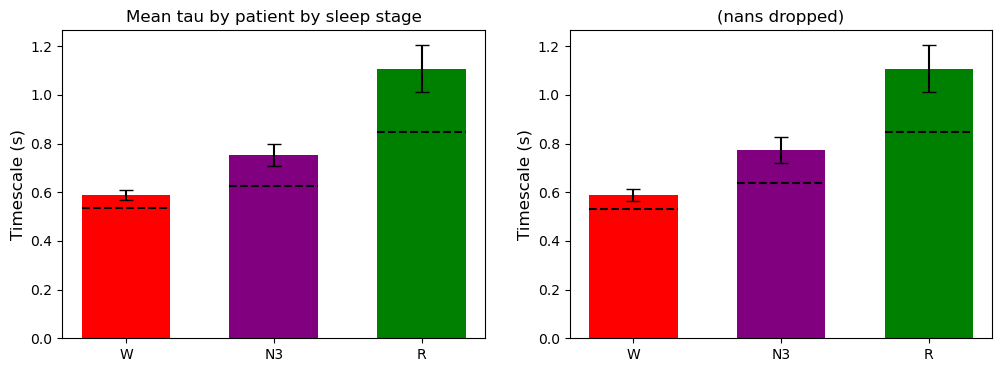

In [129]:
df_taus_pat = df_taus[["pat", "tau_W", "tau_N3", "tau_R"]].groupby("pat").mean()

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("Mean tau by patient by sleep stage")
plt.ylabel("Timescale (s)", fontsize=12)

# Drop patients without sleep
df_taus_pat = df_taus_pat.dropna()
plt.subplot(1, 2, 2)
plt.bar(
    ["W", "N3", "R"],
    df_taus_pat[["tau_W", "tau_N3", "tau_R"]].mean(),
    yerr=df_taus_pat[["tau_W", "tau_N3", "tau_R"]].sem(),
    color=["r", "purple", "g"],
    capsize=5,
    width=0.6,
)
plt.plot(
    [-0.3, 0.3], [df_taus_pat["tau_W"].median(), df_taus_pat["tau_W"].median()], "k--"
)
plt.plot(
    [0.7, 1.3], [df_taus_pat["tau_N3"].median(), df_taus_pat["tau_N3"].median()], "k--"
)
plt.plot(
    [1.7, 2.3], [df_taus_pat["tau_R"].median(), df_taus_pat["tau_R"].median()], "k--"
)
plt.title("(nans dropped)")
plt.ylabel("Timescale (s)", fontsize=12)
plt.show()

Mean and median by brain region:

In [130]:
df_taus_reg = df_taus[["region", "tau_W", "tau_N3", "tau_R"]].copy() #groupby("region").mean()
df_taus_reg = pd.melt(
    df_taus_reg.reset_index(),
    id_vars="region",
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_reg["stage"] = df_taus_reg["stage"].str.replace("tau_", "")
df_taus_reg

,region,stage,tau
0,Middle temporal gyrus,W,0.500
1,Middle temporal gyrus,W,0.500
2,Middle temporal gyrus,W,0.375
3,Middle temporal gyrus,W,0.500
4,Medial frontal cortex,W,0.500
...,...,...,...
5311,Postcentral gyrus (including medial segment),R,5.125
5312,Frontal operculum,R,0.500
5313,Frontal operculum,R,0.750
5314,Supplementary motor cortex,R,3.500


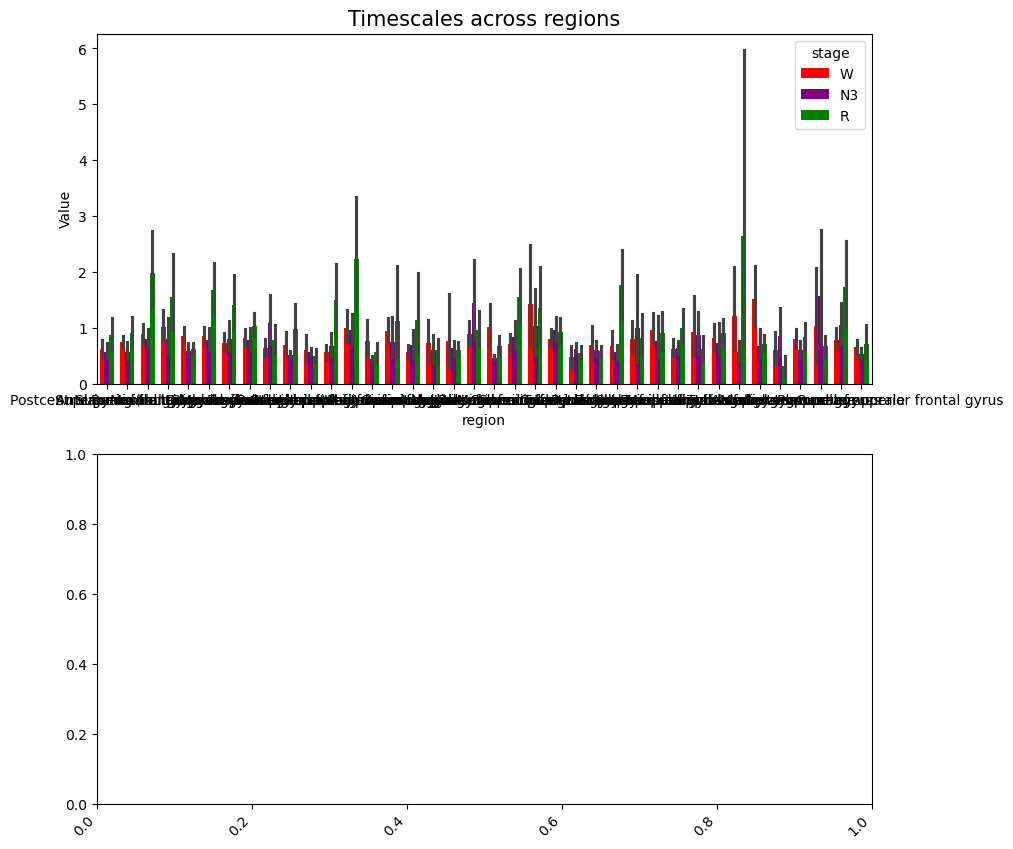

In [ ]:
fig, axs = plot_stages_diff(df_taus_reg, "tau")

plt.show()

Same plot for lobes:

In [131]:
df_regions_info = pd.read_csv(base_path.joinpath("RegionInformation.csv"), index_col=0)
df_regions_info["Region name"] = df_regions_info["Region name"].str.strip("'")
df_regions_info.set_index("Region name", inplace=True)

df_taus_lobe = df_taus.copy()
df_taus_lobe.insert(2, "lobe", df_taus_lobe["region"].apply(
    lambda x: df_regions_info.loc[x, "Lobe"]
))
df_taus_lobe.drop(columns="region", inplace=True)
df_taus_lobe.rename(columns={"lobe": "region"}, inplace=True)
df_taus_lobe

,pat,chan,region,tau_W,tau_N3,tau_R
0,1,GD001Lc_11,Temporal,0.500,NaN,NaN
1,1,GD001Lc_12,Temporal,0.500,NaN,NaN
2,1,GD001Lc_13,Temporal,0.375,NaN,NaN
3,1,GD001Lc_14,Temporal,0.500,NaN,NaN
4,1,GD001Lo_1,Frontal,0.500,NaN,NaN
...,...,...,...,...,...,...
1767,110,NG110RG614,Parietal,1.125,0.500,5.125
1768,110,NG110RG64,Frontal,0.500,0.375,0.500
1769,110,NG110RG65,Frontal,0.500,0.375,0.750
1770,110,NG110RI101,Frontal,0.500,0.500,3.500


In [132]:
df_taus_lobe = df_taus_lobe[["region", "chan", "tau_W", "tau_N3", "tau_R"]].copy() #.groupby("region").mean()
df_taus_lobe = pd.melt(
    df_taus_lobe.reset_index(),
    id_vars=["region", "chan"],
    value_vars=["tau_W", "tau_N3", "tau_R"],
    var_name="stage",
    value_name="tau",
)
df_taus_lobe["stage"] = df_taus_lobe["stage"].str.replace("tau_", "")
df_taus_lobe

,region,chan,stage,tau
0,Temporal,GD001Lc_11,W,0.500
1,Temporal,GD001Lc_12,W,0.500
2,Temporal,GD001Lc_13,W,0.375
3,Temporal,GD001Lc_14,W,0.500
4,Frontal,GD001Lo_1,W,0.500
...,...,...,...,...
5311,Parietal,NG110RG614,R,5.125
5312,Frontal,NG110RG64,R,0.500
5313,Frontal,NG110RG65,R,0.750
5314,Frontal,NG110RI101,R,3.500


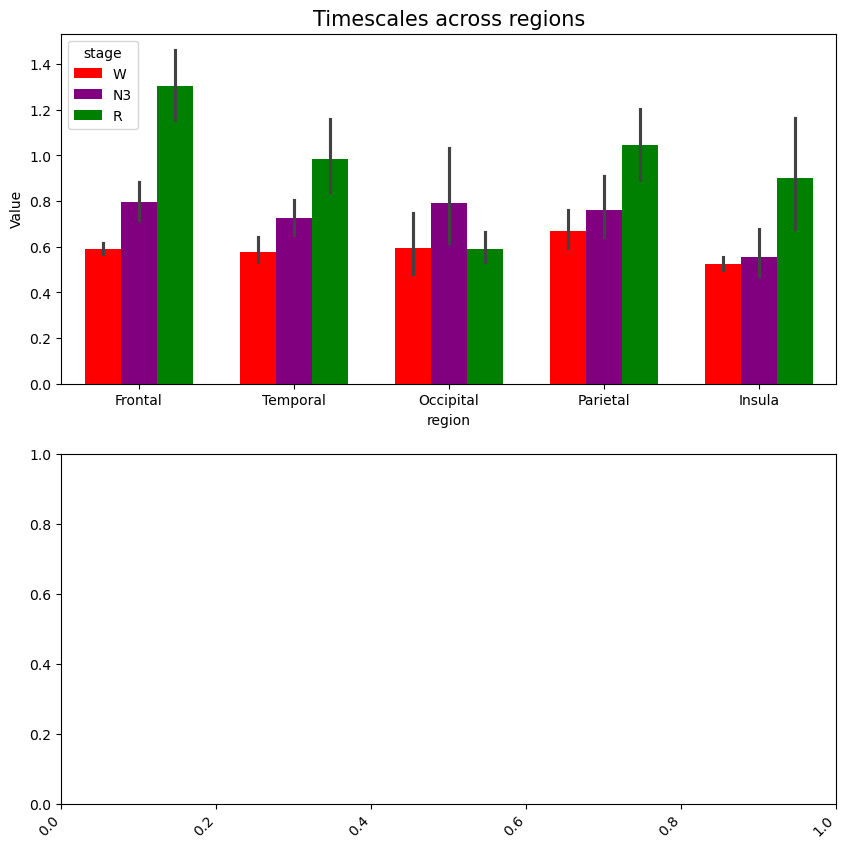

In [133]:
fig, axs = plot_stages_diff(df_taus_lobe, "tau", avg="mean")

plt.show()